In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
dataset = '../datasets/jena_climate/jena_climate_2009_2016.csv'

In [4]:
df = pd.read_csv(dataset, index_col=0)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df_normalized = (df - df.mean())/df.std()
df_normalized = df_normalized.reset_index(drop=True)
df_normalized.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.874229,-2.074010,-2.127439,-2.058613,1.049500,-1.323973,-1.535254,-0.780586,-1.536971,-1.539461,2.293603,-0.010271,-0.018931,-0.258921
1,0.880211,-2.120310,-2.173297,-2.115071,1.055569,-1.336894,-1.556764,-0.782628,-1.555795,-1.560710,2.344885,-0.015008,-0.022553,-0.445812
2,0.875425,-2.132182,-2.185056,-2.119528,1.085916,-1.339478,-1.559154,-0.784670,-1.559560,-1.563071,2.355891,-0.023106,-0.035159,-0.036268
3,0.873032,-2.108438,-2.160363,-2.083871,1.104124,-1.333018,-1.544814,-0.786712,-1.544501,-1.548905,2.329625,-0.020814,-0.037042,0.268295
4,0.873032,-2.103690,-2.156835,-2.079413,1.098055,-1.331726,-1.542424,-0.786712,-1.544501,-1.546544,2.324872,-0.021120,-0.035159,0.456339


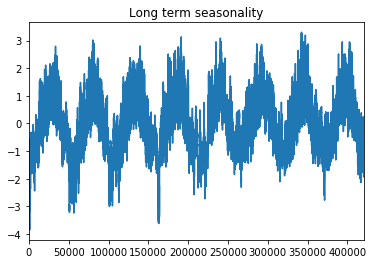

In [6]:
df_normalized['T (degC)'].plot()
plt.title('Long term seasonality')
plt.show()

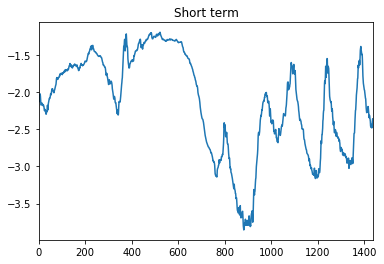

In [7]:
df_normalized['T (degC)'][:1440].plot()
plt.title('Short term')
plt.show()

In [8]:
def generator(data, lookback, delay, min_index=0, max_index=None,
              shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = data.shape[0] - delay - 1
    stop = min_index + lookback 
    
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, batch_size)
            
        else:
            batch_stop = min(stop + batch_size, max_index)
            rows = np.arange(stop, batch_stop, 1)
            stop += len(rows)
            
            if  stop + batch_size >= max_index:
                stop = min_index + lookback #Cycle generator back to beginning
            
        samples = np.zeros( (len(rows), lookback//step, data.shape[-1]) )
        targets = np.zeros( (len(rows),) )
        
        for idx, row in enumerate(rows):
            indices = range(row-lookback, row, step)
            samples[idx] = data.iloc[indices].values
            targets[idx] = data.iloc[row + delay]['T (degC)']
        yield samples, targets  

In [9]:
lookback = 1440
delay = 144
batch_size = 128
step = 6

In [47]:
train_gen = generator(df_normalized, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, batch_size=batch_size, step=step)
val_gen = generator(df_normalized, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=False, batch_size=batch_size, step=step)
test_gen = generator(df_normalized, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=False, batch_size=batch_size, step=step)

train_steps = 200000 - lookback
val_steps = 300000 - 200001 - lookback
test_steps = df_normalized.shape[0] - 300001 - lookback

### Models

#### Naive model

In [18]:
%%time 

# Baseline
# Predict future temperature to be the current temperature 
# Calculate MAE

def evaluate_naive_method():
    batch_mae = []
    for idx in range(0, val_steps, batch_size):
            sample, target = next(val_gen)
            preds = sample[:, -1, 1]
            mae = np.mean(np.abs(preds - target))
            batch_mae.append( mae )
    avg_mae = np.mean(batch_mae)
    print('Avg mae: {}'.format(avg_mae))
    print('Celsius mae: {}'.format(avg_mae*df.std()[1]))
    return avg_mae

evaluate_naive_method()

Avg mae: 0.30451654590151545
Celsius mae: 2.5650540787337666
CPU times: user 42.6 s, sys: 579 ms, total: 43.2 s
Wall time: 43.4 s


#### Simple NN

In [19]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

In [30]:
model = Sequential()
model.add( Flatten( input_shape=(lookback // step, df_normalized.shape[-1]) ) )
model.add( Dense( 32, activation='relu') )
model.add( Dense(1) )
model.compile('rmsprop', 'mae')

In [32]:
vanilla_nn_history = model.fit_generator( train_gen, steps_per_epoch=500,
                                        epochs=20,
                                        validation_data = val_gen,
                                        validation_steps = val_steps // batch_size)

Epoch 1/20
500/500 [==============================] - 82s 164ms/step - loss: 1.4571 - val_loss: 0.6351
Epoch 2/20
500/500 [==============================] - 88s 176ms/step - loss: 0.4225 - val_loss: 0.3480
Epoch 3/20
500/500 [==============================] - 83s 167ms/step - loss: 0.3170 - val_loss: 0.3329
Epoch 4/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2932 - val_loss: 0.3120
Epoch 5/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2792 - val_loss: 0.3213
Epoch 6/20
500/500 [==============================] - 88s 176ms/step - loss: 0.2692 - val_loss: 0.3347
Epoch 7/20
500/500 [==============================] - 84s 168ms/step - loss: 0.2614 - val_loss: 0.3418
Epoch 8/20
500/500 [==============================] - 85s 169ms/step - loss: 0.2539 - val_loss: 0.3307
Epoch 9/20
500/500 [==============================] - 86s 172ms/step - loss: 0.2492 - val_loss: 0.3617
Epoch 10/20
500/500 [==============================] - 85s 170ms/step - l

In [33]:
import matplotlib.pyplot as plt

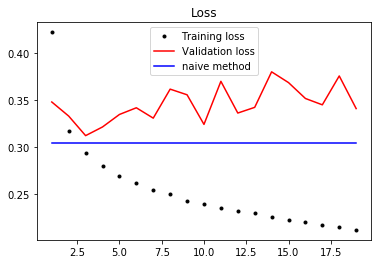

In [40]:
# Plots
hist = vanilla_nn_history.history
train_loss = hist['loss']
val_loss = hist['val_loss']
epochs = vanilla_nn_history.epoch

plt.figure()
plt.plot(epochs[1:], train_loss[1:], 'k.', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'r-', label='Validation loss')
plt.plot(epochs[1:], 0.304*np.ones_like(epochs[1:]), 'b-', label='naive method')
plt.title('Loss')
plt.legend()
plt.show()

#### GRU

In [42]:
from keras.layers import GRU

In [51]:
gru_model = Sequential()
gru_model.add( GRU(32, input_shape=(lookback // step, df_normalized.shape[-1]) ) )
gru_model.add( Dense(1) )

gru_model.compile( 'rmsprop', 'mae' )

In [53]:
gru_history = gru_model.fit_generator(train_gen, 
                        steps_per_epoch=train_steps // batch_size, 
                        epochs = 10,
                        validation_data = val_gen,
                        validation_steps = val_steps // batch_size)

Epoch 1/10
300/300 [==============================] - 278s 928ms/step - loss: 0.3144 - val_loss: 0.2896
Epoch 2/10
300/300 [==============================] - 268s 895ms/step - loss: 0.3027 - val_loss: 0.2853
Epoch 3/10
300/300 [==============================] - 274s 912ms/step - loss: 0.3000 - val_loss: 0.2924
Epoch 4/10
300/300 [==============================] - 282s 939ms/step - loss: 0.2964 - val_loss: 0.2841
Epoch 5/10
300/300 [==============================] - 274s 914ms/step - loss: 0.2920 - val_loss: 0.2896
Epoch 6/10
300/300 [==============================] - 278s 928ms/step - loss: 0.2881 - val_loss: 0.2834
Epoch 7/10
300/300 [==============================] - 272s 906ms/step - loss: 0.2851 - val_loss: 0.2822
Epoch 8/10
300/300 [==============================] - 255s 849ms/step - loss: 0.2800 - val_loss: 0.2838
Epoch 9/10
300/300 [==============================] - 248s 826ms/step - loss: 0.2765 - val_loss: 0.2811
Epoch 10/10
300/300 [==============================] - 250s 832m

In [54]:
gru_model.save_weights('models/gru-temperature.h5')

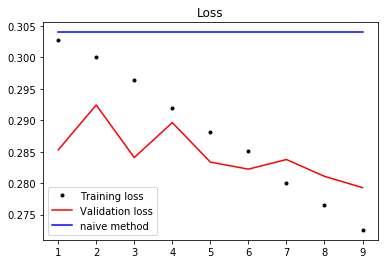

In [55]:
# Plots
hist = gru_history.history
epochs = gru_history.epoch
train_loss = hist['loss']
val_loss = hist['val_loss']

plt.figure()
plt.plot(epochs[1:], train_loss[1:], 'k.', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'r-', label='Validation loss')
plt.plot(epochs[1:], 0.304*np.ones_like(epochs[1:]), 'b-', label='naive method')
plt.title('Loss')
plt.legend()
plt.show()

#### 1D CNN

In [57]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [60]:
cnn_model = Sequential()
cnn_model.add( Conv1D( 32, 5, activation='relu', input_shape=(lookback // step, df_normalized.shape[-1])) )
cnn_model.add( MaxPooling1D(3) )

cnn_model.add( Conv1D( 32, 5, activation='relu' ))
cnn_model.add( MaxPooling1D(3) )

cnn_model.add( Conv1D( 32, 5, activation='relu' ))
cnn_model.add( GlobalMaxPooling1D() )

cnn_model.add( Dense(1) )
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 236, 32)           2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 78, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 74, 32)            5152      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 20, 32)            5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total para

In [61]:
cnn_model.compile('rmsprop', 'mae')
cnn_history = cnn_model.fit_generator(train_gen, 
                        steps_per_epoch=500, 
                        epochs = 10,
                        validation_data = val_gen,
                        validation_steps = val_steps // batch_size)
cnn_model.save_weights('models/cnn-jena.h5')

Epoch 1/10
500/500 [==============================] - 121s 242ms/step - loss: 0.4371 - val_loss: 0.4530
Epoch 2/10
500/500 [==============================] - 108s 217ms/step - loss: 0.3826 - val_loss: 0.4662
Epoch 3/10
500/500 [==============================] - 116s 233ms/step - loss: 0.3604 - val_loss: 0.4617
Epoch 4/10
500/500 [==============================] - 125s 250ms/step - loss: 0.3409 - val_loss: 0.4606
Epoch 5/10
500/500 [==============================] - 121s 242ms/step - loss: 0.3309 - val_loss: 0.4578
Epoch 6/10
500/500 [==============================] - 142s 285ms/step - loss: 0.3218 - val_loss: 0.4826
Epoch 7/10
500/500 [==============================] - 120s 240ms/step - loss: 0.3134 - val_loss: 0.4774
Epoch 8/10
500/500 [==============================] - 131s 262ms/step - loss: 0.3057 - val_loss: 0.4833
Epoch 9/10
500/500 [==============================] - 117s 235ms/step - loss: 0.2992 - val_loss: 0.4783
Epoch 10/10
500/500 [==============================] - 126s 252m

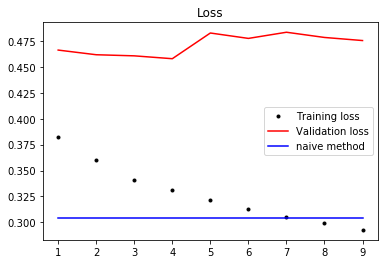

In [62]:
# Plots
hist = cnn_history.history
epochs = cnn_history.epoch
train_loss = hist['loss']
val_loss = hist['val_loss']

plt.figure()
plt.plot(epochs[1:], train_loss[1:], 'k.', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'r-', label='Validation loss')
plt.plot(epochs[1:], 0.304*np.ones_like(epochs[1:]), 'b-', label='naive method')
plt.title('Loss')
plt.legend()
plt.show()

#### CNN with GRU

In [66]:
cnn_gru_model = Sequential()
cnn_gru_model.add( Conv1D(32, 5, activation='relu', input_shape=(lookback // step, df_normalized.shape[-1])) )
cnn_gru_model.add( MaxPooling1D(3) )
cnn_gru_model.add( Conv1D(32, 5, activation='relu') )
cnn_gru_model.add( GRU(32, dropout=0.1, recurrent_dropout=0.5) )
cnn_gru_model.add( Dense(1) )
cnn_gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 236, 32)           2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 78, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 74, 32)            5152      
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [67]:
cnn_gru_model.compile( 'rmsprop', 'mae')
cnn_gru_history = cnn_gru_model.fit_generator(train_gen, 
                        steps_per_epoch=300, 
                        epochs = 10,
                        validation_data = val_gen,
                        validation_steps = val_steps // batch_size)
cnn_gru_model.save_weights('models/cnn-gru-jena.h5')

Epoch 1/10
300/300 [==============================] - 161s 538ms/step - loss: 0.3709 - val_loss: 0.3077
Epoch 2/10
300/300 [==============================] - 186s 619ms/step - loss: 0.3350 - val_loss: 0.3063
Epoch 3/10
300/300 [==============================] - 228s 760ms/step - loss: 0.3256 - val_loss: 0.2992
Epoch 4/10
300/300 [==============================] - 226s 752ms/step - loss: 0.3153 - val_loss: 0.3035
Epoch 5/10
300/300 [==============================] - 219s 731ms/step - loss: 0.3074 - val_loss: 0.2977
Epoch 6/10
300/300 [==============================] - 201s 669ms/step - loss: 0.3016 - val_loss: 0.3065
Epoch 7/10
300/300 [==============================] - 205s 685ms/step - loss: 0.2940 - val_loss: 0.3049
Epoch 8/10
300/300 [==============================] - 202s 673ms/step - loss: 0.2880 - val_loss: 0.3078
Epoch 9/10
300/300 [==============================] - 184s 613ms/step - loss: 0.2871 - val_loss: 0.3032
Epoch 10/10
300/300 [==============================] - 187s 624m

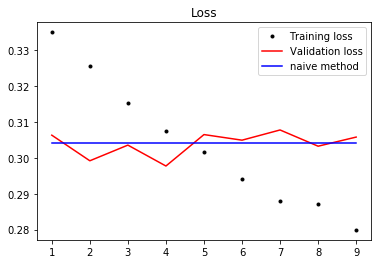

In [68]:
hist = cnn_gru_history.history
epochs = cnn_gru_history.epoch
train_loss = hist['loss']
val_loss = hist['val_loss']

plt.figure()
plt.plot(epochs[1:], train_loss[1:], 'k.', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'r-', label='Validation loss')
plt.plot(epochs[1:], 0.304*np.ones_like(epochs[1:]), 'b-', label='naive method')
plt.title('Loss')
plt.legend()
plt.show()